The goal here is to augment our data by randomly replacing annotated words with synonyms.
Note that this is going to be dangerous for short annotations as we may replace the crucial part of the annotation!
It would be worth first collection information about annotation lengths:

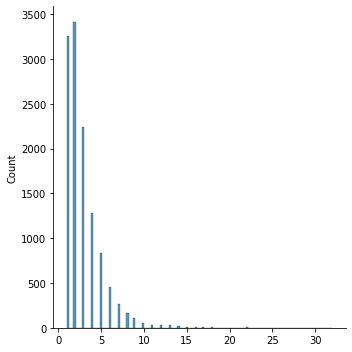

In [1]:
from project.data.data_loaders import get_clean_train_data
import seaborn as sns
data = get_clean_train_data()
lengths = []
for idx, row in data.iterrows():
    for annotation in row['annotation']:
        lengths.append(len(annotation.split(' ')))
sns.displot(lengths)

In [2]:
data

,id,case_num,pn_num,feature_num,annotation,location_raw,feature_text,pn_history,location
0,00016_000,0,16,0,[dad with recent heart attcak],[696 724],Family-history-of-MI-OR-Family-history-of-myoc...,HPI: 17yo M presents with palpitations. Patien...,"[(696, 724)]"
1,00016_001,0,16,1,"[mom with ""thyroid disease]",[668 693],Family-history-of-thyroid-disorder,HPI: 17yo M presents with palpitations. Patien...,"[(668, 693)]"
2,00016_002,0,16,2,[chest pressure],[203 217],Chest-pressure,HPI: 17yo M presents with palpitations. Patien...,"[(203, 217)]"
3,00016_003,0,16,3,"[intermittent episodes, episode]","[70 91, 176 183]",Intermittent-symptoms,HPI: 17yo M presents with palpitations. Patien...,"[(70, 91), (176, 183)]"
4,00016_004,0,16,4,[felt as if he were going to pass out],[222 258],Lightheaded,HPI: 17yo M presents with palpitations. Patien...,"[(222, 258)]"
...,...,...,...,...,...,...,...,...,...
14295,95333_912,9,95333,912,[],[],Family-history-of-migraines,Stephanie madden is a 20 year old woman compla...,[]
14296,95333_913,9,95333,913,[],[],Female,Stephanie madden is a 20 year old woman compla...,[]
14297,95333_914,9,95333,914,[photobia],[274 282],Photophobia,Stephanie madden is a 20 year old woman compla...,"[(274, 282)]"
14298,95333_915,9,95333,915,[no sick contacts],[421 437],No-known-illness-contacts,Stephanie madden is a 20 year old woman compla...,"[(421, 437)]"


Since the annotations are very specific to the data and pretty tight as bounding boxes, it may be better instead to just replace random words in the text **excluding** the annotated portion. 

In [3]:
r = data.iloc[3]
class Interval:
    def __init__(self, start, end):
        self.start = start
        self.end = end
    def __contains__(self, otherInterval: 'Interval'):
        return otherInterval.start >= self.start and otherInterval.end <= self.end
    def overlapsWith(self, otherInterval: 'Interval'):
        return otherInterval.start <= self.end and otherInterval.end >= self.start

In [34]:
from nltk.corpus import wordnet as wn
def get_synonyms(word):
    """Get the synonyms of word from Wordnet."""
    lemmas = set().union(*[s.lemmas() for s in wn.synsets(word)])
    return list(set(l.name().lower().replace("_", " ") for l in lemmas) - {word})
get_synonyms('computer')

['information processing system',
 'calculator',
 'computing device',
 'estimator',
 'figurer',
 'data processor',
 'electronic computer',
 'computing machine',
 'reckoner']

In [53]:
print(r['annotation'])

['intermittent episodes', 'episode']


In [130]:
import random
tokens = [token for token in nlp(r['pn_history']) if token.is_alpha]
def overlaps_with_label(token): 
    """Check if a token overlaps with a label."""
    for (s, e) in r['location']:
        if s <= token.idx < e:
            return True
    return False
tokens = [token for token in tokens if not overlaps_with_label(token) and len(get_synonyms(token.text)) > 0]
to_replace = random.choice(tokens[:5])
replacement_synonym = random.choice(get_synonyms(to_replace.text))
print(r['annotation'])
print(r['location'])
print(to_replace.text, replacement_synonym)
new_text = r['pn_history'].replace(to_replace.text, replacement_synonym)
new_loc = [(s, e) if s < to_replace.idx else (s + len(replacement_synonym) - len(to_replace.text), e + len(replacement_synonym) - len(to_replace.text)) for (s, e) in r['location'] ]
print(new_loc)
print(new_text)

['intermittent episodes', 'episode']
[(70, 91), (176, 183)]
reports story
[(68, 89), (174, 181)]
HPI: 17yo M presents with palpitations. Patient story 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. 
PMHx: none
Rx: uses friends adderrall
FHx: mom with "thyroid disease," dad with recent heart attcak
All: none
Immunizations: up to date
SHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfr

In [36]:
import random
enriched_sentence = []
for token in nlp(r['pn_history']):
    if not token.pos_ == 'NOUN':
        enriched_sentence.append(token.text)
    else:
        synonyms = get_synonyms(token.text)
        if synonyms:
            enriched_sentence.append('--'+random.choice(synonyms)+'--')
        else:
            enriched_sentence.append(token.text)
print(' '.join(enriched_sentence))

HPI : 17yo M presents with --shaking-- . --affected role-- reports 3 - 4 --calendar month-- of intermittent --episode-- of " --warmheartedness-- beating / pounding out of my --bureau-- . " 2 --clarence day-- ago during a --association football-- --gage-- had an --instalment-- , but this --prison term-- had --bureau-- --hale-- and felt as if he were going to pass out ( did not lose conciousness ) . Of note patient --indorse-- abusing adderall , primarily to study ( 1 - 3 --meter-- per --calendar week-- ) . Before recent --association football-- --spunky-- , took adderrall --dark-- before and --dawning-- of --spirited-- . --refuse-- --curtness-- of --breathing spell-- , --sweating-- , --fever-- , --gelidity-- , --vexation-- , --jade-- , --alteration-- in --eternal rest-- , --convert-- in --sight-- / --find out-- , abdominal paun , --commute-- in --gut-- or urinary --habit-- . 
 PMHx : none 
 Rx : uses --admirer-- adderrall 
 FHx : --ma-- with " --thyroid gland-- disease , " --pappa-- wit

In [8]:
healthcare_domains = ['finance', 'banking']
enriched_sentence = []
sentence = nlp('I want to withdraw 5,000 euros')

# For each token in the sentence
for token in sentence:
    # We get those synsets within the desired domains
    synsets = token._.wordnet.wordnet_synsets_for_domain(healthcare_domains)
    if not synsets:
        enriched_sentence.append(token.text)
    else:
        lemmas_for_synset = [lemma for s in synsets for lemma in s.lemma_names()]
        # If we found a synset in the economy domains
        # we get the variants and add them to the enriched sentence
        enriched_sentence.append('({})'.format('|'.join(set(lemmas_for_synset))))

# Let's see our enriched sentence
print(' '.join(enriched_sentence))
# >> I (need|want|require) to (draw|withdraw|draw_off|take_out) 5,000 euros
    

(iodine|I|i|ane|1|unity|single|one|ace|atomic_number_53|iodin) (require|privation|deficiency|wishing|lack|neediness|desire|need|deprivation|wish|want) to (remove|take_out|disengage|take_away|take|retire|swallow|move_back|call_back|pull_back|withdraw|draw_back|seclude|recall|draw|adjourn|pull_away|recede|pull_in_one's_horns|draw_off|back_out|sequestrate|bow_out|crawfish|call_in|retreat|crawfish_out|unsay|take_back|sequester|back_away) 5,000 (euro)


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")
tokens = nlp(r['pn_history'])

for token in tokens:
    print(token.text, token.pos_, token.dep_)

HPI PROPN dep
: PUNCT punct
17yo PROPN appos
M PROPN nsubj
presents VERB ROOT
with ADP prep
palpitations NOUN pobj
. PUNCT punct
Patient NOUN nsubj
reports VERB ROOT
3 NUM nummod
- SYM punct
4 NUM nummod
months NOUN dobj
of ADP prep
intermittent ADJ amod
episodes NOUN pobj
of ADP prep
" PUNCT punct
heart NOUN compound
beating VERB pcomp
/ PUNCT punct
pounding VERB advcl
out ADP prep
of ADP prep
my PRON poss
chest NOUN pobj
. PUNCT punct
" PUNCT punct
2 NUM nummod
days NOUN npadvmod
ago ADV advmod
during ADP prep
a DET det
soccer NOUN compound
game NOUN pobj
had VERB ROOT
an DET det
episode NOUN dobj
, PUNCT punct
but CCONJ cc
this DET det
time NOUN nsubj
had VERB conj
chest NOUN compound
pressure NOUN dobj
and CCONJ cc
felt VERB conj
as SCONJ mark
if SCONJ mark
he PRON nsubj
were AUX aux
going VERB advcl
to PART aux
pass VERB xcomp
out ADP prt
( PUNCT punct
did AUX aux
not PART neg
lose VERB ccomp
conciousness NOUN dobj
) PUNCT punct
. PUNCT punct
Of ADP advmod
note VERB ROOT
patient A

In [ ]:
from nltk.corpus import wordnet
from itertools import chain
import random
def get_random_synonym(word: str) -> str:
    synonyms = wordnet.synsets(word)
    synonyms = list(set(chain.from_iterable([word.lemma_names() for word in synonyms])))
    return random.choice(synonyms)
print(get_random_synonym('change'))
print(get_random_synonym('house'))

switch
sign_of_the_zodiac


In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/evanvogelbaum/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
for chunk in nlp('This is a test sentence'):
    print(type(chunk))

<class 'spacy.tokens.token.Token'>
<class 'spacy.tokens.token.Token'>
<class 'spacy.tokens.token.Token'>
<class 'spacy.tokens.token.Token'>
<class 'spacy.tokens.token.Token'>


In [ ]:
print(chunk, chunk.i, chunk.i + len(chunk))

sentence 4 12


In [ ]:
chunk.pos

92